## Analysis of CC-DIS events: Cross-section, projection for Sivers asymmetry, neutrino-jet azimuthal correlations. 

In [2]:
import time
import ROOT
import numpy as np
import pandas as pd
import root_pandas as rpd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.colors import LogNorm
from root_pandas import read_root
from numpy import inf
from matplotlib import rc
rc('text', usetex=True)

Welcome to JupyROOT 6.15/01


In [3]:
def applyCut(inputDataframe, cut, text=None):
    dataframe = inputDataframe
    nbeforecut = dataframe.shape[0]
    cutDataframe = dataframe.query(cut)
    if text:
        print text, cutDataframe.shape[0], ' fraction kept: %2.1f'%(100.0*float(cutDataframe.shape[0])/nbeforecut)
    return cutDataframe

In [4]:
def getJetData(inputFiles):
    
    cols = []
    scalar = []
    scalar.append('evid')
    scalar.append('xsec')
    scalar.append('ntrials')    
    scalar.append('x')
    scalar.append('y')
    scalar.append('Q2')
    scalar.append('W2')
    scalar.append('e_eta')
    scalar.append('e_theta')
    scalar.append('e_p')
    scalar.append('e_pt')
    scalar.append('quark_id')

    cols.append('n_total')
    cols.append('jet_eta')
    cols.append('jet_theta')
    cols.append('jet_p')
    cols.append('jet_pt')
    cols.append('dphi_e_jet')
    cols.append('dR_q_jet')
    
    lists = scalar
    dataframes = []
    for inputFilename in inputFiles:
        start = time.time()
        df = read_root(inputFilename, columns=lists+cols,flatten=cols)
        dataframes.append(df)
        end = time.time()
        print '\n', 'Processed', inputFilename, 'in',  '%2.1f'%(end-start), 'seconds'
    return pd.concat([x for x in dataframes])

In [5]:
def getLeptonData(inputFiles):
    cols = []
    scalar = []
    scalar.append('evid')
    scalar.append('xsec')
    scalar.append('ntrials')    
    scalar.append('x')
    scalar.append('y')
    scalar.append('Q2')
    scalar.append('W2')
    scalar.append('e_eta')
    scalar.append('e_theta')
    scalar.append('e_p')
    scalar.append('e_pt')
    scalar.append('quark_id')

    
    lists = scalar
    dataframes = []
    for inputFilename in inputFiles:
        start = time.time()
        df = read_root(inputFilename, columns=lists+cols,flatten=cols)
        dataframes.append(df)
        end = time.time()
        print '\n', 'Processed', inputFilename, 'in',  '%2.1f'%(end-start), 'seconds'
    return pd.concat([x for x in dataframes])

## Event and jet selections

In [6]:
##Selection on event variables
def applyEventCuts(df):
    print '################### ' 
    print 'Applying event selection'
    temp = df 
    temp = applyCut(temp, 'y < 0.95 and y>0.01', '0.01 < y < 0.95')
    #temp = applyCut(temp, 'y < 0.85 and y>0.1', '0.1 < y < 0.85')

    temp = applyCut(temp, 'Q2>100', 'Q2>100')
    temp.eval('logQ2= log(Q2)/2.3025850', inplace=True)
    temp.eval('logx= log(x)/2.3025850', inplace=True)
    print '################### \n' 
    return temp

In [7]:
## Selection on event and jet variables
def applyJetCuts(df):
    print '################### ' 
    print 'Applying jet selection'
    temp = df
    temp = applyCut(temp, 'jet_pt>5', ' jet pT > 5 GeV') 
    temp = applyCut(temp, 'dphi_e_jet > 2.74', 'dphi_e_jet>3.14159-0.4')
    temp.eval('dphi = 3.14159-dphi_e_jet', inplace=True)
    print '################### \n' 

    return temp

In [8]:
def printSummary(df):
    print df['e_pt'].mean(), ' mean lepton pt'
    print df['y'].mean(), ' mean inelasticity'
    print df['jet_p'].mean(), ' mean jet p'
    print df['jet_pt'].mean(), ' mean jet pT'
    print df['jet_pt'].describe()

    print df['x'].mean(), ' mean x'
    print df['Q2'].mean(), ' mean Q2'
    print df['Q2'].describe()
    return

## Get electron dataframe, apply event selection

In [9]:
df_inclusive = getLeptonData(['CC_10_275.root'])
#df_inclusive = getLeptonData(['CC_10_100.root'])

xsec = np.mean(df_inclusive['xsec'])
xsec = xsec*1e9
print 'xsection %2.2f [pb]' %(xsec)
accepted = df_inclusive.shape[0]
print 'accepted events' , accepted
to_cross_section = xsec/(1.0*accepted)
lumi = 100 # in units of fb-1. 
to_counts = to_cross_section*1000*lumi #1000 accounts to pass from pb to fb
##Apply selection
df_inclusive = applyEventCuts(df_inclusive)



Processed CC_10_275.root in 0.3 seconds
xsection 14.27 [pb]
accepted events 25000
################### 
Applying event selection
0.01 < y < 0.95 23944  fraction kept: 95.8
Q2>100 23943  fraction kept: 100.0
################### 



## Inclusive DIS cross-section

In [10]:
##Total cross-section: 
integrated_rate    = 1000*lumi*xsec #multiply by 1000 and then 100 to get integrated yield for 100 fb-1
print 'Integrated rate %2.3f [M]' %(integrated_rate/1e6)

Integrated rate 1.427 [M]


## Plot all variables in dataframe 

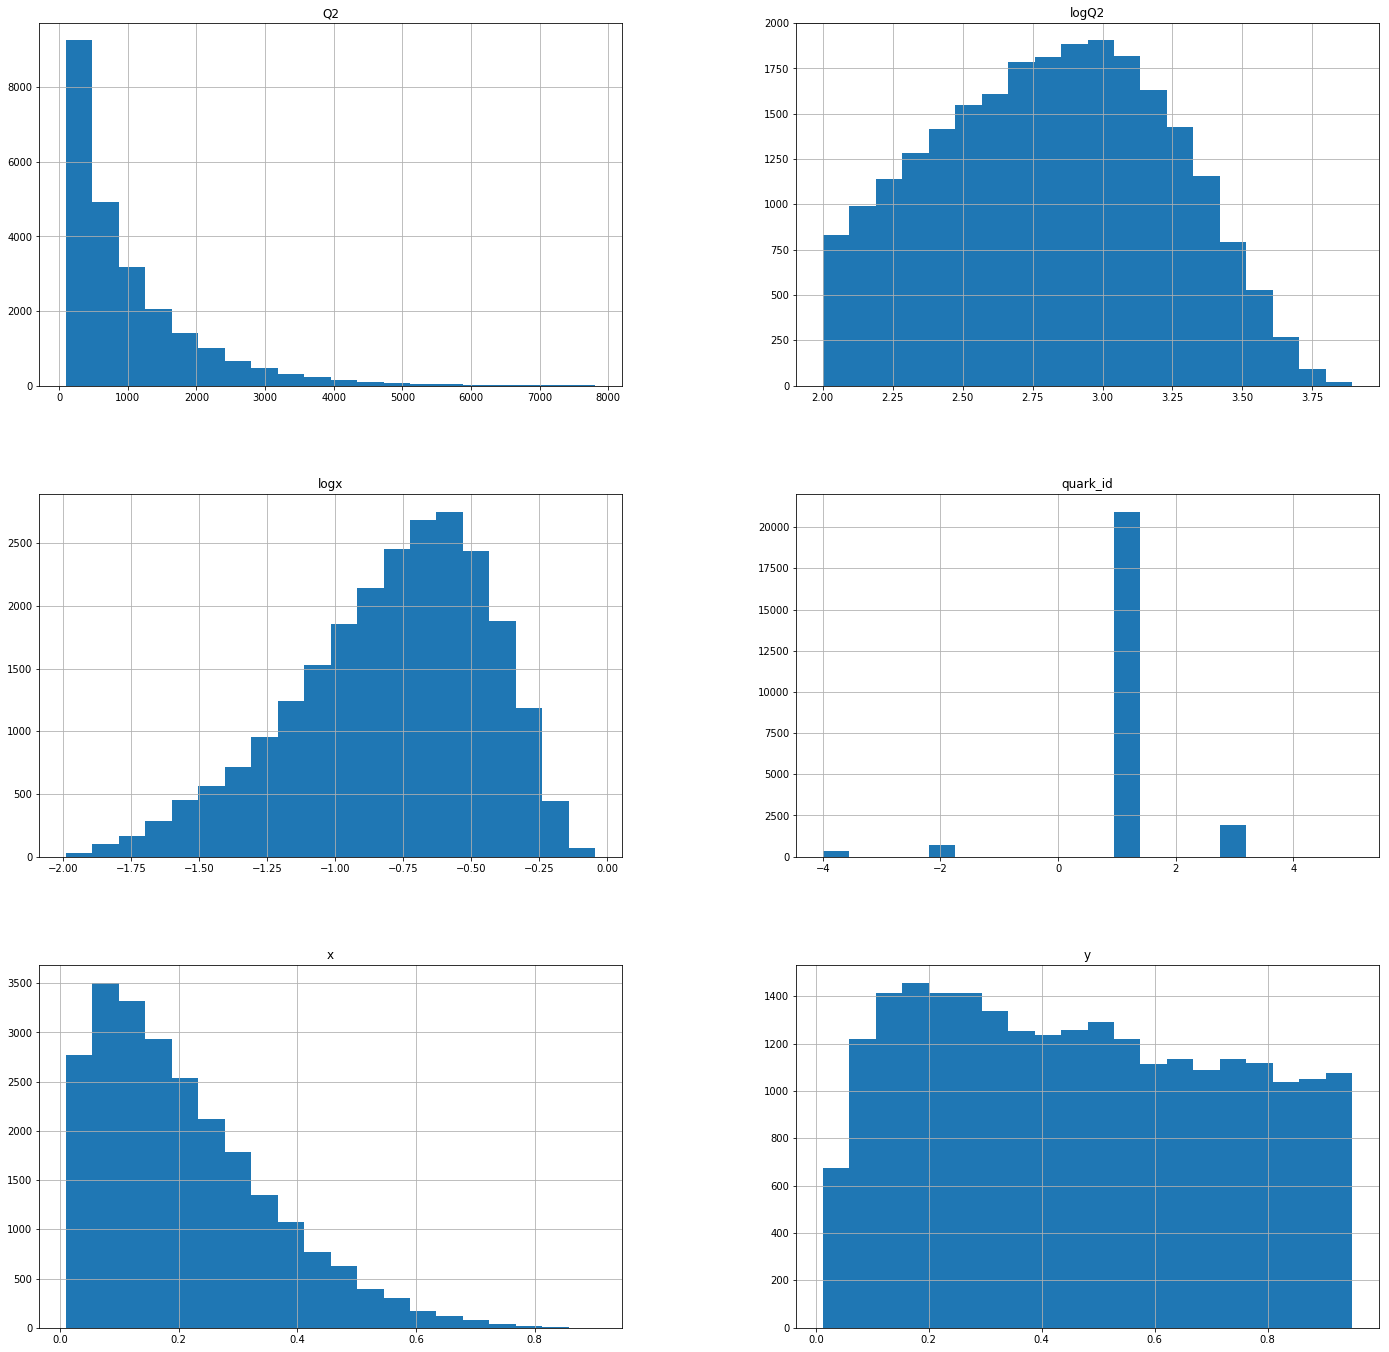

In [11]:
rc('text', usetex=False)
df_inclusive.hist(figsize=(24,24),bins=20,column=['x','Q2','logx','logQ2','y','quark_id'])
plt.show()

## Cross-section inclusive, x Q2. It agrees with calculation shown in https://arxiv.org/abs/1309.5327

<Container object of 3 artists>

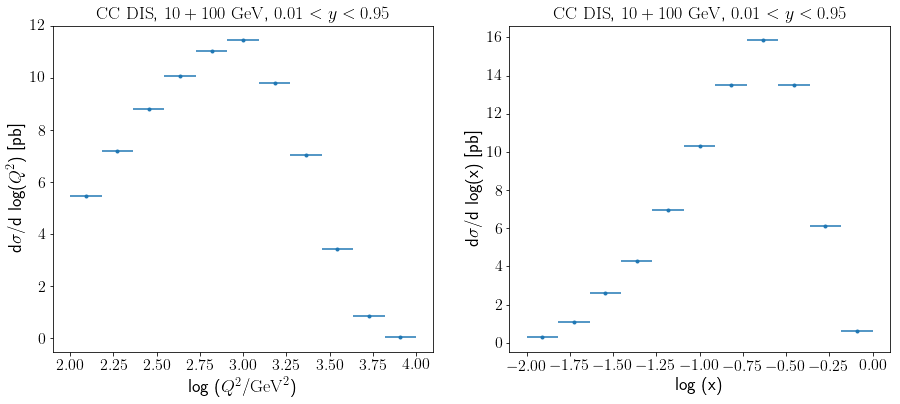

In [12]:
rc('text', usetex=True)

fig, ax1 = plt.subplots(figsize=(15,6))

##Electron distribution
plt.subplot(121)
y, x  = np.histogram(df_inclusive['logQ2'],bins=np.linspace(2,4,12))
xerr = (x[1:] - x[:-1])/2.0
x = (x[1:]+x[:-1])/2
y = y*to_cross_section
y = y/(xerr*2.0)

plt.errorbar(x,y,  xerr = xerr, fmt='.',ls='none')
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.xlabel('log ($Q^{2}$/$\mathrm{GeV}^{2}$)',fontsize=18)
plt.ylabel(r'd$\sigma$/d log($Q^{2}$) [pb]',fontsize=18)
plt.title('$\mathrm{CC}\ \mathrm{DIS}$, $10+100$ $\mathrm{GeV}$, $0.01<y<0.95$', fontsize=18)


plt.subplot(122)
y, x  = np.histogram(df_inclusive['logx'],bins=np.linspace(-2.0,0,12))
xerr = (x[1:] - x[:-1])/2.0
x = (x[1:]+x[:-1])/2
y = y*to_cross_section
y = y/(xerr*2.0)

plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.xlabel('log (x)',fontsize=18)
plt.ylabel(r'd$\sigma$/d log(x) [pb]',fontsize=18)
plt.title('$\mathrm{CC}\ \mathrm{DIS}$, $10+100$ $\mathrm{GeV}$, $0.01<y<0.95$', fontsize=18)
plt.errorbar(x,y,  xerr = xerr, fmt='.',ls='none')

## Jet dataframe

In [13]:
df_jet      = getJetData(['CC_10_275.root'])
#df_jet      = getJetData(['CC_10_100.root'])

df_jet = applyEventCuts(df_jet)
df_jet = applyJetCuts(df_jet)


Processed CC_10_275.root in 0.6 seconds
################### 
Applying event selection
0.01 < y < 0.95 24866  fraction kept: 97.7
Q2>100 24865  fraction kept: 100.0
################### 

################### 
Applying jet selection
 jet pT > 5 GeV 24865  fraction kept: 100.0
dphi_e_jet>3.14159-0.4 23572  fraction kept: 94.8
################### 



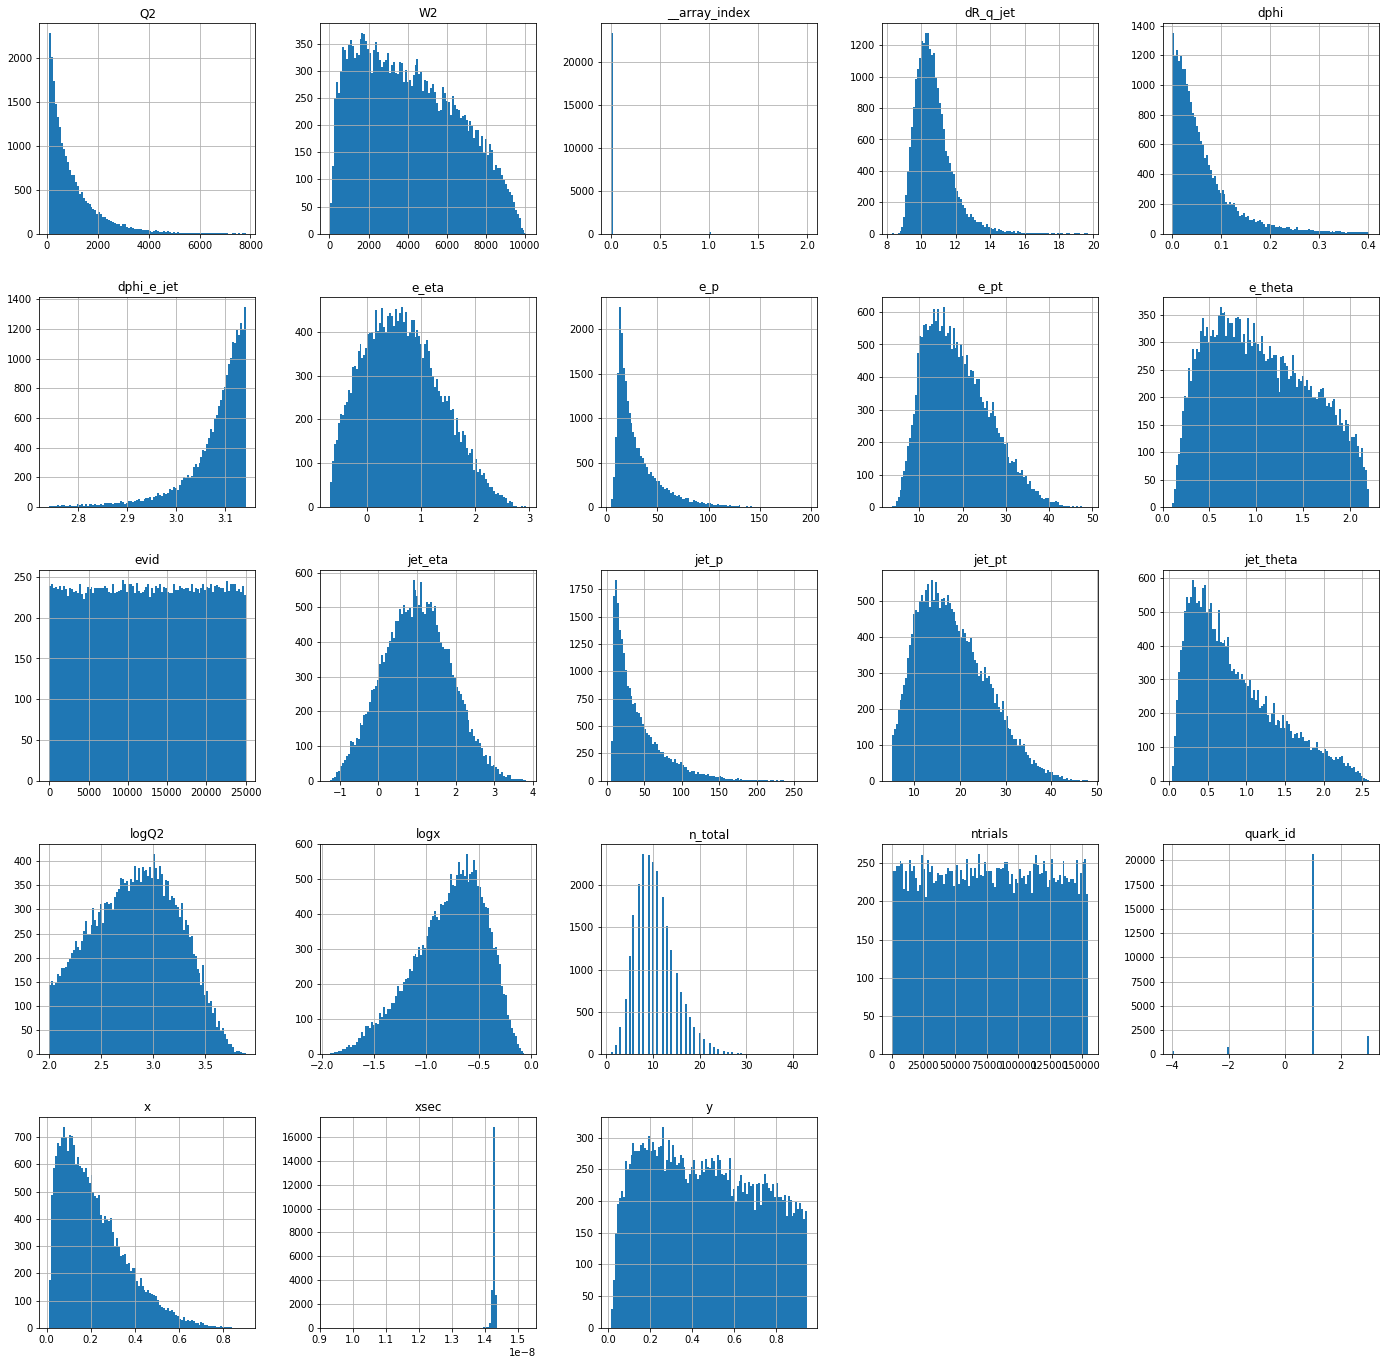

In [14]:
rc('text', usetex=False)
df_jet.hist(figsize=(24,24),bins=100)
plt.show()

## Cross-section plot with mean-x

Cross section [5975.2239849  5706.02402165 4475.43094148 3350.86326444 1993.41608344
  503.08852695   80.17059336]


/usr/local/lib/python2.7/dist-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


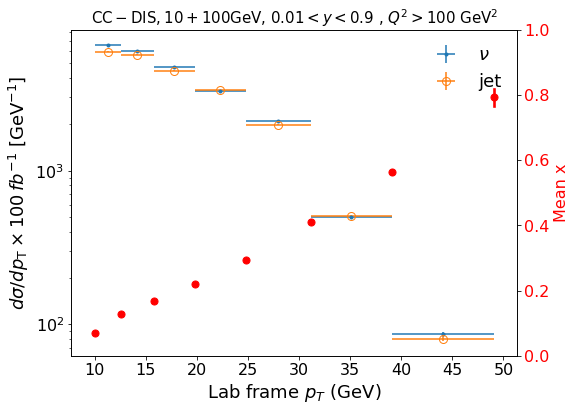

In [15]:
import seaborn as sns
nbins = 8
minpt = 10
maxpt = df_inclusive['e_pt'].max()
fig, ax1 = plt.subplots(figsize=(8,6))

##Electron distribution
y, x  = np.histogram(df_inclusive.query('e_pt>5 and quark_id==3')['e_pt'],bins=np.logspace(np.log10(minpt),np.log10(maxpt),nbins))
xerr = (x[1:] - x[:-1])/2.0
x = (x[1:]+x[:-1])/2
y = y*to_counts
yerr = np.sqrt(y)

y = y/(xerr*2.0)
yerr = yerr/(xerr*2.0)

plt.errorbar(x,y, yerr=yerr,  xerr = xerr, fmt='.',ls='none',label=r'$\nu$')


y, x  = np.histogram(df_jet.query('jet_pt>5 and quark_id==3')['jet_pt'],bins=np.logspace(np.log10(minpt),np.log10(maxpt),nbins))
xerr = (x[1:] - x[:-1])/2.0
x = (x[1:]+x[:-1])/2
y = y*to_counts

yerr = np.sqrt(y)
y = y/(xerr*2.0)
yerr = yerr/(xerr*2.0)
print 'Cross section', y 
plt.errorbar(x,y, yerr=yerr,xerr = xerr, fmt='o',ls='none',markersize=8,fillstyle='none',label='jet')


plt.yscale('log')
ax1.set_xlabel('Lab frame $p_{T}$ (GeV)' ,fontsize=18)
ax1.set_ylabel(r'$d\sigma/d p_{\mathrm{T}} \times 100 \, fb^{-1}$ [$\mathrm{GeV^{-1}}$]', fontsize=18)
#plt.title('$\mathrm{CC-DIS}, 10+275 \mathrm{GeV}$, $0.01 < y < 0.9$ , $Q^2 > 100\ \mathrm{GeV^2}$',   fontsize=15)
plt.title('$\mathrm{CC-DIS}, 10+100 \mathrm{GeV}$, $0.01 < y < 0.9$ , $Q^2 > 100\ \mathrm{GeV^2}$',   fontsize=15)

plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.legend(loc='best',frameon=False,fontsize=18)#bbox_to_anchor=(0.40, 0.85


#ax1.set_ylim([1e3,1e5])

###Mean x vs pT
ax2 = ax1.twinx()
ax2.tick_params(axis='y', labelcolor='red')
sns.regplot(df_inclusive['e_pt'], df_inclusive['x'], x_bins=np.logspace(np.log10(minpt),np.log10(maxpt),nbins),fit_reg=None,color='red')
ax2.set_ylabel('Mean x' ,color='red',fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
ax2.set_ylim([0.0,1.0])
#ax2.scale('log')
plt.savefig('CrossSection_CC.png', bbox_inches='tight')
plt.savefig('CrossSection_CC.pdf', bbox_inches='tight')

plt.legend(loc='best',frameon=False,fontsize=15,bbox_to_anchor=(0.40, 0.85))

## strange scattered

Cross section [65369.39797708 69363.85451321 63863.68914911 48802.60653037
 30388.32029468  9759.91742292  1002.13241696]
Cross section [5975.2239849  5706.02402165 4475.43094148 3350.86326444 1993.41608344
  503.08852695   80.17059336]


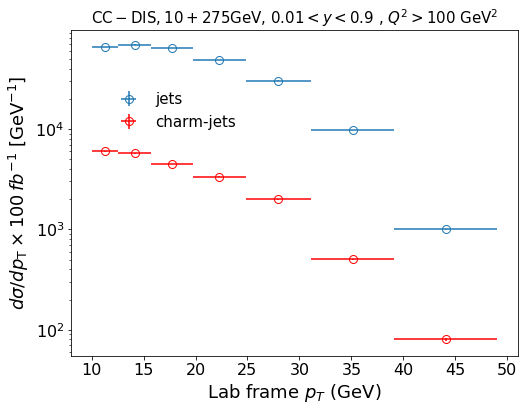

In [18]:
import seaborn as sns
nbins = 8
minpt = 10
maxpt = df_inclusive['e_pt'].max()
fig, ax1 = plt.subplots(figsize=(8,6))

##Electron distribution
#y, x  = np.histogram(df_inclusive.query('e_pt>5')['e_pt'],bins=np.logspace(np.log10(minpt),np.log10(maxpt),nbins))
#xerr = (x[1:] - x[:-1])/2.0
#x = (x[1:]+x[:-1])/2
#y = y*to_counts
#yerr = np.sqrt(y)

#y = y/(xerr*2.0)
#yerr = yerr/(xerr*2.0)

#plt.errorbar(x,y, yerr=yerr,  xerr = xerr, fmt='.',ls='none',label=r'$\nu$')




y, x  = np.histogram(df_jet.query('jet_pt>5')['jet_pt'],bins=np.logspace(np.log10(minpt),np.log10(maxpt),nbins))
xerr = (x[1:] - x[:-1])/2.0
x = (x[1:]+x[:-1])/2
y = y*to_counts

yerr = np.sqrt(y)
y = y/(xerr*2.0)
yerr = yerr/(xerr*2.0)
print 'Cross section', y 
plt.errorbar(x,y, yerr=yerr,xerr = xerr, fmt='o',ls='none',markersize=8,fillstyle='none',label='jets')




y, x  = np.histogram(df_jet.query('jet_pt>5 and quark_id==3')['jet_pt'],bins=np.logspace(np.log10(minpt),np.log10(maxpt),nbins))
xerr = (x[1:] - x[:-1])/2.0
x = (x[1:]+x[:-1])/2
y = y*to_counts

yerr = np.sqrt(y)
y = y/(xerr*2.0)
yerr = yerr/(xerr*2.0)
print 'Cross section', y 
plt.errorbar(x,y, yerr=yerr,xerr = xerr, fmt='o',ls='none',markersize=8,fillstyle='none',label='charm-jets',color='red')


plt.yscale('log')
ax1.set_xlabel('Lab frame $p_{T}$ (GeV)' ,fontsize=18)
ax1.set_ylabel(r'$d\sigma/d p_{\mathrm{T}} \times 100 \, fb^{-1}$ [$\mathrm{GeV^{-1}}$]', fontsize=18)
#plt.title('$\mathrm{CC-DIS}, 10+275 \mathrm{GeV}$, $0.01 < y < 0.9$ , $Q^2 > 100\ \mathrm{GeV^2}$',   fontsize=15)
plt.title('$\mathrm{CC-DIS}, 10+275 \mathrm{GeV}$, $0.01 < y < 0.9$ , $Q^2 > 100\ \mathrm{GeV^2}$',   fontsize=15)

plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.legend(loc='best',frameon=False,fontsize=18)#bbox_to_anchor=(0.40, 0.85


#ax1.set_ylim([1e3,1e5])

###Mean x vs pT
#ax2 = ax1.twinx()
#ax2.tick_params(axis='y', labelcolor='grey')
#sns.regplot(df_inclusive['e_pt'], df_inclusive['x'], x_bins=np.logspace(np.log10(minpt),np.log10(maxpt),nbins),fit_reg=None,color='grey')
#ax2.set_ylabel('Mean x' ,color='grey',fontsize=16)
#plt.yticks(fontsize=16)
#plt.xticks(fontsize=16)
#ax2.set_ylim([0.0,1.0])
##ax2.scale('log')
plt.savefig('CrossSection_CC_strange.png', bbox_inches='tight')
plt.savefig('CrossSection_CC_strange.pdf', bbox_inches='tight')

plt.legend(loc='best',frameon=False,fontsize=15,bbox_to_anchor=(0.40, 0.85))

(array([   0.,    0.,    0.,    0.,    0., 1881.,    0.,    0.,    0.,
           0.]),
 array([2.5, 2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5]),
 <a list of 10 Patch objects>)

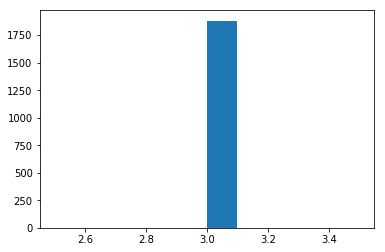

In [81]:
plt.hist(df_jet.query('quark_id==3')['quark_id'])

Cross section [5975.2239849  5706.02402165 4475.43094148 3350.86326444 1993.41608344
  503.08852695   80.17059336]


<Container object of 3 artists>

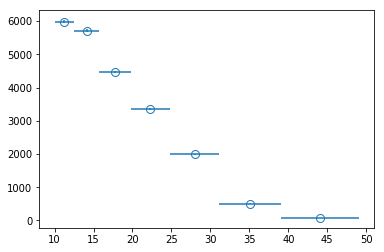

In [82]:
y, x  = np.histogram(df_jet.query('jet_pt>5 and quark_id==3')['jet_pt'],bins=np.logspace(np.log10(minpt),np.log10(maxpt),nbins))
xerr = (x[1:] - x[:-1])/2.0
x = (x[1:]+x[:-1])/2
y = y*to_counts

yerr = np.sqrt(y)
y = y/(xerr*2.0)
yerr = yerr/(xerr*2.0)
print 'Cross section', y 
plt.errorbar(x,y, yerr=yerr,xerr = xerr, fmt='o',ls='none',markersize=8,fillstyle='none',label='jet')

## Cross-section

SyntaxError: Python keyword not valid identifier in numexpr query (<unknown>, line 1)

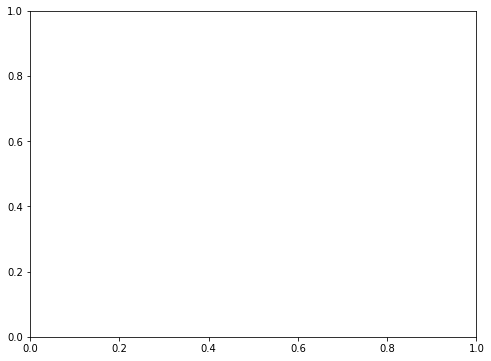

In [72]:
import seaborn as sns
nbins = 10
minimo = 0.2
maximo = 1.0
fig, ax1 = plt.subplots(figsize=(8,6))


#y, x  = np.histogram(df_jet.query('e_pt>10 and jet_pt>10')['x'],bins=np.logspace(np.log10(minimo),np.log10(maximo),nbins))
y, x  = np.histogram(df_jet.query('e_pt>10 and jet_pt>10')['x'],bins=np.linspace(minimo,maximo,nbins))

xerr = (x[1:] - x[:-1])/2.0
x = (x[1:]+x[:-1])/2
y = y*to_counts

yerr = np.sqrt(y)
#y = y/(xerr*2.0)
#yerr = yerr/(xerr*2.0)
print 'Cross section', y 
plt.errorbar(x,y, yerr=yerr,xerr = xerr, fmt='o',ls='none',markersize=8,fillstyle='none',label='jet',color='black')


plt.yscale('log')
ax1.set_xlabel('x' ,fontsize=18)
ax1.set_ylabel(r'$d\sigma \times 100 \, fb^{-1}$', fontsize=18)
#plt.title('$\mathrm{CC-DIS}, 10+275 \mathrm{GeV}$, $0.01 < y < 0.9$ , $Q^2 > 100\ \mathrm{GeV^2}$',   fontsize=15)
plt.title('$\mathrm{CC-DIS}, 10+275 \mathrm{GeV}$, $0.01 < y < 0.9$ , $MET> 10\ \mathrm{GeV}$',   fontsize=15)

plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
#plt.legend(loc='best',frameon=False,fontsize=18)#bbox_to_anchor=(0.40, 0.85


#ax1.set_ylim([1e3,1e5])

##Mean x vs pT
#ax2 = ax1.twinx()
#ax2.tick_params(axis='y', labelcolor='red')
#sns.regplot(df_jet['x'], df_jet['jet_eta'], x_bins=np.linspace(0,3,nbins),fit_reg=None,color='red')
#ax2.set_ylabel('Mean x' ,color='red',fontsize=16)
#plt.yticks(fontsize=16)
#plt.xticks(fontsize=16)
#ax2.set_ylim([10.0,40.0])
plt.savefig('CrossSection_CC_xdependence.png', bbox_inches='tight')
plt.savefig('CrossSection_CC_xdependence.pdf', bbox_inches='tight')

#plt.legend(loc='best',frameon=False,fontsize=15,bbox_to_anchor=(0.40, 0.85))

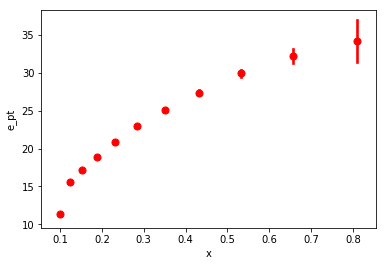

In [33]:
sns.regplot(df_inclusive['x'], df_inclusive['e_pt'], x_bins=np.logspace(np.log10(minimo),np.log10(maximo),nbins),fit_reg=None,color='red')


In [18]:
print df_inclusive['e_pt'].max()

29.318813


## Sivers asymmetry for neutrino-jet correlation!

In [19]:
dilution_factor =0.7 # proton polarization for single-spin asymmetries ()
efficiency = 0.5 #overall-efficiency
penalty = 1.0 #sqrt(2) coming from separating Sivers v Collins v something else
lumi = 100 # in units of fb-1. 100 is expected in a year? (check)

def fake_A(x,slope=0.05):
    return slope*np.ones(len(x))

Q2 > 100.00 and Q2<200.00
9.7466  mean lepton pt
0.32671916  mean inelasticity
18.304893  mean jet p
9.456501  mean jet pT
count    19599.000000
mean         9.456501
std          2.025600
min          5.001390
25%          8.029063
50%          9.555742
75%         10.903189
max         17.244980
Name: jet_pt, dtype: float64
0.17119542  mean x
147.28107  mean Q2
count    19599.000000
mean       147.281067
std         28.855215
min        100.004364
25%        122.056400
50%        145.841339
75%        171.932335
max        199.986145
Name: Q2, dtype: float64
###########
Q2 > 200.00 and Q2<500.00
12.690205  mean lepton pt
0.47349852  mean inelasticity
19.331142  mean jet p
12.338093  mean jet pT
count    35928.000000
mean        12.338093
std          3.263499
min          5.000091
25%         10.068648
50%         12.572971
75%         14.692606
max         22.934408
Name: jet_pt, dtype: float64
0.21857123  mean x
332.1419  mean Q2
count    35928.000000
mean       332.141907
std     

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in divide


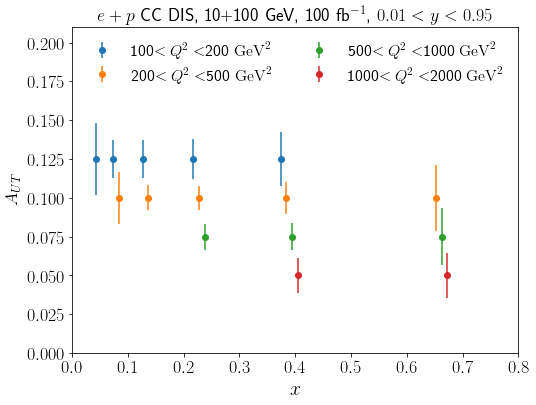

In [25]:
rc('text', usetex=True)

fig = plt.figure(figsize=(8,6))
asymmetry = [0.125,0.1,0.075,0.05,0.025]
#colores = ['black','blue','red','purple']


for counter,edges in enumerate([(100,200),(200,500), (500,1000),(1000,2000)]):#, (2000,5000)]):
    selection = 'Q2 > %2.2f and Q2<%2.2f'%(edges[0],edges[1])
    df_cut = df_jet.query(selection)
    print selection
    printSummary(df_cut)
    print '###########'
    y, x  = np.histogram(df_cut['x'],bins=np.logspace(-1.5,-0.09,7))
    x = (x[1:]+x[:-1])/2
    x = x + 0.01*counter
    y = y*to_counts
    y = y*efficiency 
    y[y<2000] = 0
    # take efficiency hit
    erry = np.divide(1,dilution_factor*np.sqrt(y),out=np.zeros_like(y)) #follow standard formula for asymmetry uncertainty
    x[erry == inf] = 1000
    plt.errorbar(x,y=fake_A(x,asymmetry[counter]) , yerr=erry, fmt='o',ls='none',label='%2.0f$<Q^{2}<$%2.0f $\mathrm{GeV}^{2}$'%(edges[0],edges[1]))
    
    #plt.errorbar(x,y,label='%2.0f$<Q^{2}<$%2.0f'%(edges[0],edges[1]))

    #plt.errorbar(x,y,label='%2.2f$<x<$%2.2f'%(edges[0],edges[1]))
####
plt.ylim([0.0,0.21])
plt.xlim([0.00,0.8])
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
#plt.yscale('log')

#plt.xscale('log')
plt.title('$e+p$ CC DIS, 10+100 GeV, 100 fb$^{-1}$, $0.01<y<0.95$', fontsize=18)
plt.legend(loc='best', fontsize=16,frameon=False,ncol=2)
plt.ylabel('$A_{UT}$',fontsize=18)
plt.xlabel('$x$',fontsize=20)
plt.savefig('AUT_CC_Sivers_xdependence.png', bbox_inches='tight')
plt.savefig('AUT_CC_Sivers_xdependence.pdf', bbox_inches='tight')

## Selected jet distributions

In [ ]:
rc('text', usetex=False)

df_jet.query('jet_pt>5').hist(figsize=(12,12),bins=100, column=['e_pt','Q2','jet_pt','jet_eta'])
plt.show()



## Dphi distribution. Neutrino-jet azimuthal correlation

12.6633005  mean lepton pt
0.47607833  mean inelasticity
18.673365  mean jet p
12.370303  mean jet pT
count    38004.000000
mean        12.370303
std          1.428940
min         10.000028
25%         11.132351
50%         12.298975
75%         13.575829
max         14.999814
Name: jet_pt, dtype: float64
0.23856466  mean x
443.37543  mean Q2
count    38004.000000
mean       443.375427
std        359.287964
min        100.004364
25%        212.792458
50%        315.182449
75%        537.904083
max       3381.742676
Name: Q2, dtype: float64
###########
17.2202  mean lepton pt
0.47880873  mean inelasticity
25.99119  mean jet p
17.134935  mean jet pT
count    20843.000000
mean        17.134935
std          1.404243
min         15.000085
25%         15.909502
50%         16.969706
75%         18.245866
max         19.999662
Name: jet_pt, dtype: float64
0.36424047  mean x
689.2892  mean Q2
count    20843.000000
mean       689.289185
std        372.293823
min        114.037498
25%        431

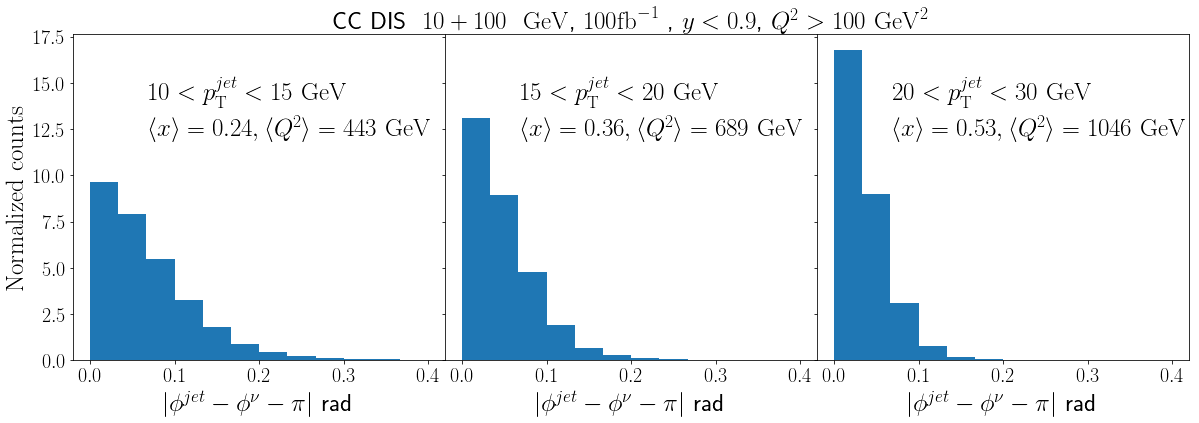

In [29]:
from matplotlib import rc
rc('text', usetex=True)


fig, axs = plt.subplots(1, 3,sharey=True, figsize=(20,6), gridspec_kw={'wspace':0, 'hspace':0})


#for counter,edges in enumerate([(10,20), (20,30),(30,40)]):
for counter,edges in enumerate([(10,15), (15,20),(20,30)]):

    df_cut = df_jet.query('jet_pt > %2.2f and jet_pt<%2.2f'%(edges[0],edges[1]))
    printSummary(df_cut)
    print '###########'
    
    axs[counter].hist(df_cut['dphi'],bins=12,range=(0,0.4),normed=True)
    
    axs[counter].xaxis.set_label_text(r'$|\phi^{jet}-\phi^\nu-\pi|$ rad', fontsize=25)
    axs[0].yaxis.set_label_text(r'$\mathrm{Normalized\ counts}$', fontsize=25)
    axs[counter].tick_params('both',labelsize=20)
    plt.yticks(fontsize=20)
    #axs[counter].text(0.1,6, , fontsize=20)
    #axs[counter].text(0.1,8, '$\sqrt{s} = 89 \, \mathrm{GeV}$ \n $0.1 < y < 0.85$ \n $p_T^{jet} > 4 \, \mathrm{GeV/c}$', fontsize=20)
    #plt.legend(prop={'size': 20}, frameon=False, loc='best')
    axs[counter].text(0.07,12, r' $ %2.0f< p_{\mathrm{T}}^{jet} < %2.0f$'%(edges[0],edges[1]) + '$\ \mathrm{ GeV}$ \n' +
                      r'$\langle x \rangle = %2.2f, \langle Q^{2} \rangle = %2.0f \ \mathrm{GeV}$'%(df_cut['x'].mean(), df_cut['Q2'].mean()), fontsize=25)

axs[1].set_title(r'CC\ DIS \ $10+100$ \ $\mathrm{GeV}$,  $100\mathrm{fb}^{-1}$ , $y<0.9$, $Q^{2}>100$ $\mathrm{GeV}^{2}$',fontsize=25)  

plt.savefig('CC_LeptonJetAzimuthal.png', bbox_inches='tight')
plt.savefig('CC_LeptonJetAzimuthal.pdf', bbox_inches='tight')

